# Adding Multiple Wells

This notebook shows how a WellModel can be used to fit multiple wells with one response function. The influence of the individual wells is scaled by the distance to the observation point. 

**Authors**
- _R.A. Collenteur, Artesia Water 2018_
- _D.A. Brakenhoff, Artesia Water 2019_
- _R.C. Caljé, Artesia Water 2020_

Import the requisite modules

In [1]:
import numpy as np
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]
Numpy version: 1.18.5
Scipy version: 1.4.0
Pandas version: 1.0.5
Pastas version: 0.15.0b


## Load data from a Menyanthes file
Menyanthes is timeseries analysis software used by many people in the Netherlands. In this example a Menyanthes-file with one observation-series is imported, and simulated. There are several stresses in the Menyanthes-file, among which are three groundwater extractions with a significant influence on groundwater head.

Import the Menyanthes-file with observations and stresses.

In [2]:
fname = '../data/MenyanthesTest.men'
meny = ps.read.MenyData(fname)

Get the distances of the extractions to the observation well. Extraction 1 is about two times as far from the observation well as extraction 2 and 3. We will use this informatio later in our WellModel.

In [3]:
# Get distances from metadata
xo = meny.H["Obsevation well"]['xcoord']
yo = meny.H["Obsevation well"]['ycoord']
distances = []
extraction_names = ['Extraction 1', 'Extraction 2', 'Extraction 3']
for extr in extraction_names:
    xw = meny.IN[extr]["xcoord"]
    yw = meny.IN[extr]["ycoord"]
    distances.append(np.sqrt((xo-xw)**2 + (yo-yw)**2))
df = pd.DataFrame(distances, index = extraction_names, columns=['Distance to Observation well'])
df

,Distance to Observation well
Extraction 1,5076.464352
Extraction 2,2281.964490
Extraction 3,2783.783397


Then plot the observations, together with the diferent stresses in the Menyanthes file.

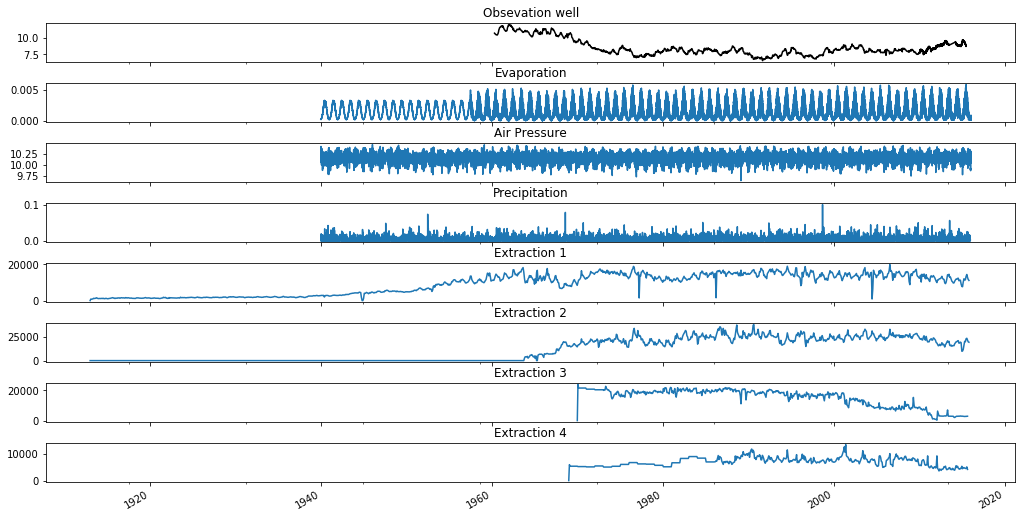

In [5]:
# plot some series
f1, axarr = plt.subplots(len(meny.IN)+1, sharex=True, figsize=(14,7))
oseries = meny.H['Obsevation well']["values"]
oseries.plot(ax=axarr[0], color='k')
axarr[0].set_title(meny.H['Obsevation well']["Name"])
for i, val in enumerate(meny.IN.items()):
    name, data = val
    data["values"].plot(ax=axarr[i+1])
    axarr[i+1].set_title(name)
plt.tight_layout(pad=0)

## Create a model with a separate StressModel for each extraction

First we create a model with a separate StressModel for each groundwater extraction. First we create a model with the heads timeseries and add recharge as a stress.

In [6]:
ml = ps.Model(ps.TimeSeries(meny.H['Obsevation well']['values'], name="heads"))

INFO: Cannot determine frequency of series heads


Get the precipitation and evaporation timeseries and round the index to remove the hours from the timestamps.

In [7]:
IN = meny.IN['Precipitation']['values']
IN.index = IN.index.round("D")
IN.name = "prec"
IN2 = meny.IN['Evaporation']['values']
IN2.index = IN2.index.round("D")
IN2.name = "evap"

Create a recharge stressmodel and add to the model.

In [8]:
sm = ps.StressModel2([IN, IN2], ps.Gamma, 'Recharge')
ml.add_stressmodel(sm)

INFO: Inferred frequency from time series prec: freq=D 
INFO: Inferred frequency from time series evap: freq=D 


Get the extraction timeseries.

In [10]:
stresses = []
for name in extraction_names:
    stress = ps.TimeSeries(meny.IN[name]['values'], name=name, settings='well')
    # the unit is allreay daily, so we need te set to_daily_unit to None
    stress.update_series(to_daily_unit=None)
    stresses.append(stress)    

INFO: Cannot determine frequency of series Extraction 1
INFO: Time Series Extraction 1: values of stress were transformed to daily values (frequency not altered) with: divide
INFO: Cannot determine frequency of series Extraction 2
INFO: Time Series Extraction 2: values of stress were transformed to daily values (frequency not altered) with: divide
INFO: Cannot determine frequency of series Extraction 3
INFO: Time Series Extraction 3: values of stress were transformed to daily values (frequency not altered) with: divide


Add each of the extractions as a separate StressModel.

In [11]:
for stress in stresses:
    sm = ps.StressModel(stress, ps.Hantush, stress.name, up=False)
    ml.add_stressmodel(sm)

INFO: Time Series Extraction 1 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 3 was sampled down to freq D with method timestep_weighted_resample


Solve the model.

In [12]:
ml.solve()

INFO: Time Series Extraction 1 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 3 was sampled down to freq D with method timestep_weighted_resample
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Model Results heads                       Fit Statistics
nfev     40                     EVP                95.66
nobs     2843                   R2                  0.96
noise    True                   RMSE                0.19
tmin     1960-04-28 00:00:00    AIC                23.82
tmax     2015-06-29 00:00:00    BIC               113.11
freq     D                      Obj                10.99
warmup   3650 days 00:00:00     ___                     
solver   LeastSquares           ___                     

Parameters (15 were optimized)
                      optimal   stderr     initial  vary
Recharge_A        1620.839504   ±8.95%  210.498526  True
Recharge_n           1.156804   ±3.11%    1.000000  True
Recharge_a         608.157605  ±13.13%   10.000000  True
Recharge_f          -1.354190   ±9.14%   -1.000000  True
Extraction 1_A      -0.000256  ±11.81%   -0.000178  True
Extraction 1_rho     1.266872  ±27.88%    1.000000  True
Extraction 1_cS   2717.391270  ±34.01%  100.000000  True

### Visualize the results
Plot the decomposition to see the individual influence of each of the wells.

In this graph we see that the influence of extraction 1 is very smooth.

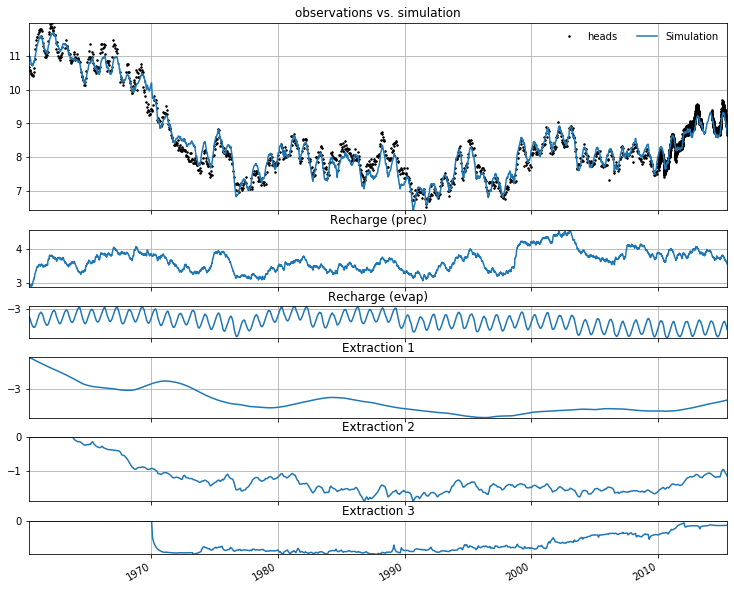

In [11]:
ml.plots.decomposition();

We can calculate the gain of each extraction (quantified as the effect on the groudnwater level of an exttraction of 1000 m3/d).

We can see that the gain of extraction 1 is largest, even though this extraction is furthest away from the observation well. The model has difficulty in separating the influence of the three extractions.

In [12]:
for i in range(3):
    name = extraction_names[i]
    sm = ml.stressmodels[name]
    p = ml.get_parameters(name)
    gain = sm.rfunc.gain(p) * 1000000 / 365.25
    print("{0}: gain = {1:.2f} m / milion m^3/year".format(name, gain))
    df.at[name, 'gain StressModel'] = gain

Extraction 1: gain = -0.70 m / milion m^3/year
Extraction 2: gain = -0.17 m / milion m^3/year
Extraction 3: gain = -0.13 m / milion m^3/year


## Create a model with a WellModel
Because we want to make the result more fysically feasable, we model the three extractions with a WellModel. This WellModel takes into acount the distances from the three extractions to the observation well, and assumes constant geohydrological properties.

First we delete the existing StressModels with the well-data.

In [13]:
for i in range(3):
    name = extraction_names[i]
    ml.del_stressmodel(name)

We have all the information we need to create a WellModel:
- timeseries for each of the extractions, these are passed as a list of stresses
- distances from each extraction to the observation point, note that the order of these distances must correspond to the order of the stresses.

Note: the WellModel only works with a special version of the Hantush response function called `HantushWellModel`. This is because the response function must support scaling by a distance $r$. The HantushWellModel response function has been modified to support this. The Hantush response normally takes three parameters: the gain $A$, $\rho$ and $cS$, where parameter $\rho = \tfrac{r}{\lambda}$. This special version accepts 4 parameters: it interprets that fourth parameter as the distance $r$, and uses it to scale the $A$ and $\rho$ parameters accordingly. 

Create the WellModel and add to the model

In [14]:
w = ps.WellModel(stresses, ps.HantushWellModel, "Wells", distances, settings="well")
ml.add_stressmodel(w)

INFO: Time Series Extraction 2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 3 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 1 was sampled down to freq D with method timestep_weighted_resample


Solve the model.

As we can see, the fit with the measurements (EVP) is a litte lower now. The model is more fysically feasable however, because of the regularisation introduced by the WellModel.

In [15]:
ml.solve()

INFO: Time Series Extraction 2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 3 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 1 was sampled down to freq D with method timestep_weighted_resample
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Model Results heads                   Fit Statistics
nfev     53                     EVP            93.69
nobs     2843                   R2              0.94
noise    True                   RMSE            0.23
tmin     1960-04-28 00:00:00    AIC            11.73
tmax     2015-06-29 00:00:00    BIC            65.30
freq     D                      Obj            11.50
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (9 were optimized)
                 optimal   stderr      initial  vary
Recharge_A   1267.748006  ±16.72%   210.498526  True
Recharge_n      1.004414   ±3.74%     1.000000  True
Recharge_a    834.620351  ±28.05%    10.000000  True
Recharge_f     -1.998963  ±13.59%    -1.000000  True
Wells_A        -0.000079  ±44.00%    -0.002620  True
Wells_lab    2691.752398  ±32.48%  5076.464352  True
Wells_cS      846.070144  ±32.83%   100.000000  True
constant_d     12.216469   ±4.74%     8.557530  True
noise_alpha    

### Visualize the results
Plot the decomposition to see the individual influence of each of the wells

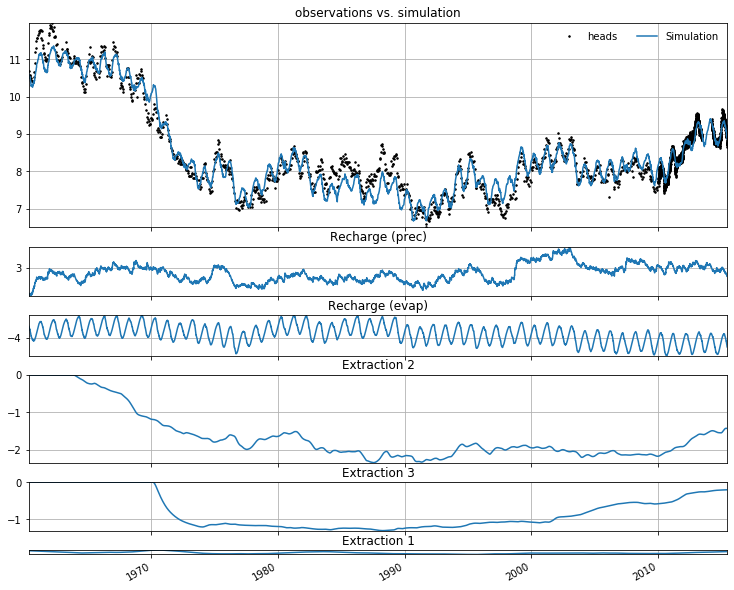

In [16]:
ml.plots.decomposition();

Plot the stacked influence of each of the individual extraction wells in the results plot

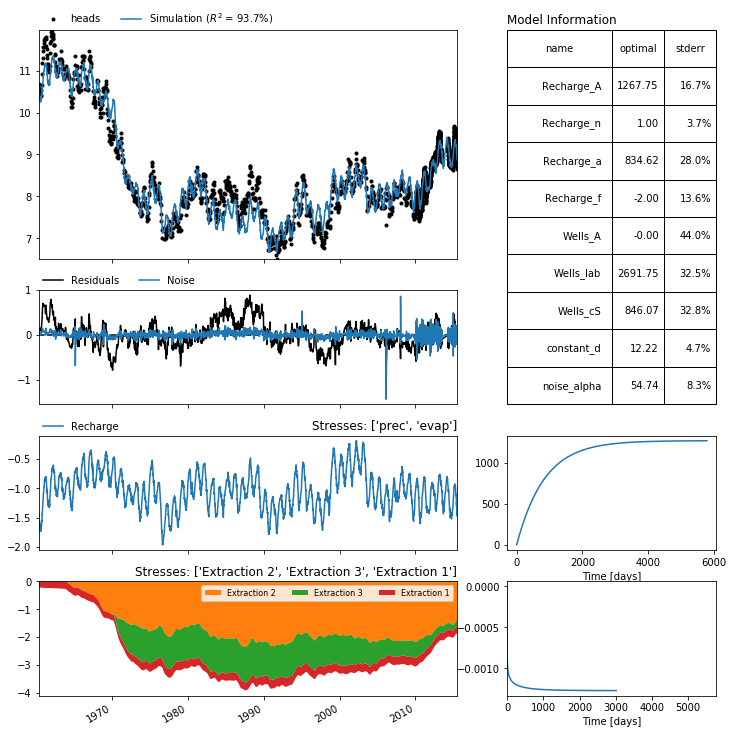

In [17]:
ml.plots.stacked_results(figsize=(10, 10));

Get parameters for each well (including the distance) and calculate the gain. The WellModel reorders the stresses from close to the observation well, to far from the observation well. We have take this into account during the post-processing.

The gain of extraction 1 is lower than the gain of extraction 2 and 3. This will allways be the case in a WellModel when the distance from the observation well to extraction 1 is larger than the distance to extraction 2 and 3.

In [18]:
wm = ml.stressmodels["Wells"]
for i in range(3):
    p = wm.get_parameters(model=ml, istress=i)
    gain = wm.rfunc.gain(p) * 1000000 / 365.25
    name = wm.stress[i].name
    print("{0}: gain = {1:.2f} m / milion m^3/year".format(name, gain))
    df.at[name, 'gain WellModel'] = gain

Extraction 2: gain = -0.23 m / milion m^3/year
Extraction 3: gain = -0.17 m / milion m^3/year
Extraction 1: gain = -0.06 m / milion m^3/year


## Compare individual StressModels and WellModel

Compare the gains that were calculated by the individual StressModels and the WellModel.

In [19]:
df

,Distance to Observation well,gain StressModel,gain WellModel
Extraction 1,5076.464352,-0.702379,-0.056970
Extraction 2,2281.964490,-0.172493,-0.228548
Extraction 3,2783.783397,-0.127756,-0.174252
